In [1]:
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

### 各ユーザのAccuracyのデータのロード

In [2]:
saved_path = './each_user_result./'
# file_name = 'last-fm_each_user_ret_epoch=0.pickle'
file_name = 'each_user_ret_epoch=19.pickle'

In [3]:
with open(saved_path + file_name, 'rb') as f:
  each_user_ret = pickle.load(f)

In [4]:
each_user_ndcg = defaultdict(float)

In [5]:
each_user_ret[0]

{'user_id': 0,
 'recall': array([0.08510638, 0.12765957, 0.12765957, 0.14893617, 0.17021277]),
 'precision': array([0.2   , 0.15  , 0.1   , 0.0875, 0.08  ]),
 'ndcg': array([0.30618864, 0.41385325, 0.41385325, 0.45512116, 0.49408425]),
 'hit_ratio': array([1., 1., 1., 1., 1.]),
 'auc': 0.0,
 'top_N_items': [(1085, 12.173683),
  (10778, 11.681754),
  (23493, 11.466055),
  (8523, 11.296857),
  (11184, 11.179999),
  (11211, 11.060519),
  (2237, 11.028409),
  (19439, 10.986417),
  (9491, 10.648063),
  (10936, 10.647737),
  (14037, 10.647504),
  (10874, 10.485147),
  (9454, 10.439081),
  (9492, 10.429654),
  (8524, 10.411466),
  (23496, 10.3966),
  (8422, 10.33805),
  (7140, 10.331901),
  (9493, 10.330873),
  (7536, 10.172565),
  (2719, 10.006644),
  (9871, 9.955256),
  (10799, 9.801346),
  (9726, 9.771114),
  (2718, 9.73137),
  (7537, 9.72799),
  (2717, 9.723579),
  (23564, 9.722545),
  (13996, 9.712077),
  (8348, 9.70301),
  (2801, 9.643488),
  (23466, 9.505796),
  (2657, 9.474501),
  (61

In [6]:
each_user_recall = defaultdict(float)
for u, ret in each_user_ret.items(): 
    recall = ret['recall'][0] 
    each_user_recall[u] = recall

In [7]:
each_user_recall[610]

0.26666666666666666

In [8]:
len(each_user_ndcg)

0

In [9]:
for u, ret in each_user_ret.items(): 
    ndcg = ret['ndcg'][0] 
    each_user_ndcg[u] = ndcg

### 全ユーザのNDCG＠20のヒストグラムを作成

In [10]:
all_user_ndcg = list(each_user_ndcg.values())
all_user_ndcg = np.array(all_user_ndcg)
print(all_user_ndcg.mean())

0.13392665292409214


In [11]:
error = np.count_nonzero(all_user_ndcg == 0.0)
error_ratio = error / len(each_user_ndcg)
print('NDCG@20 が0のユーザの割合 : {}'.format(error_ratio))

NDCG@20 が0のユーザの割合 : 0.6433845370448952


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


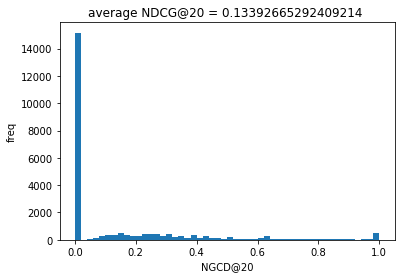

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(all_user_ndcg, bins=50)
ax.set_title('average NDCG@20 = {} '.format(all_user_ndcg.mean()))
ax.set_xlabel('NGCD@20')
ax.set_ylabel('freq')
fig.show()

### 予測がうまくいっているユーザとそうでないユーザを抽出

In [14]:
sorted_each_user_ndcg = sorted(each_user_ndcg.items(), key=lambda x:x[1], reverse=True)

In [20]:
# うまくいっているユーザ
top_ndcg_user = sorted_each_user_ndcg[:100]
top_ndcg_user = dict(top_ndcg_user)
top_ndcg_user_ids= top_ndcg_user.keys()
top_ndcg_user_score = top_ndcg_user.values()

In [21]:
# うまくいっていないユーザ
worst_ndcg_user = sorted_each_user_ndcg[-100:]
worst_ndcg_user = dict(worst_ndcg_user)
worst_ndcg_user_ids = worst_ndcg_user.keys()

In [23]:
top_ndcg_user_ids = list(top_ndcg_user_ids)
worst_ndcg_user_ids = list(worst_ndcg_user_ids)

In [24]:
save_path = './users/'
file_name = 'worst_100_users.pickle'


if not os.path.exists(save_path):
    os.makedirs(save_path)

with open(save_path + file_name, mode='wb') as f:
    pickle.dump(worst_ndcg_user_ids, f)

### 予測がうまくいった人に推薦されたアイテムを抽出

In [56]:
user_list = []
item_list = []
score_list = []

for u in top_ndcg_user_ids:
    ret = each_user_ret[u]
    data = dict(ret['top_N_items'])
    items = data.keys()
    scores = data.values()
    
    for item, score in zip(items, scores):
        user_list.append(u)
        item_list.append(item)
        score_list.append(score)

In [57]:
top_user_df = pd.DataFrame(
    data = {
        'user_id' : user_list,
        'item_id' : item_list,
        'score' : score_list
    },
    columns=['user_id', 'item_id','score']
)

top_user_df.head()

,user_id,item_id,score
0,119,5704,11.234782
1,119,5735,11.090653
2,119,10614,10.634906
3,119,10448,10.537714
4,119,1844,10.335157


### 予測がうまくいかなった人に推薦されたアイテムを抽出

In [58]:
user_list = []
item_list = []
score_list = []

for u in worst_ndcg_user_ids:
    ret = each_user_ret[u]
    data = dict(ret['top_N_items'])
    items = data.keys()
    scores = data.values()
    
    for item, score in zip(items, scores):
        user_list.append(u)
        item_list.append(item)
        score_list.append(score)

In [59]:
worst_user_df = pd.DataFrame(
    data = {
        'user_id' : user_list,
        'item_id' : item_list,
        'score' : score_list
    },
    columns=['user_id', 'item_id','score']
)

worst_user_df.head()

,user_id,item_id,score
0,23552,1540,11.776107
1,23552,5710,10.626558
2,23552,4501,10.554112
3,23552,1054,10.332048
4,23552,26628,10.311855


### アイテムのメタ情報をマージ

In [60]:
item_meta_data_df = pd.read_csv('item_meta_data.csv')
item_meta_data_df = item_meta_data_df.drop('Unnamed: 0', axis=1)
item_meta_data_df = item_meta_data_df.reset_index(drop=True)
item_meta_data_df.head()

,item_id,track_name,artist_name
0,72,Needles and Pins,Deftones
1,73,Minerva,Deftones
2,74,Good Morning Beautiful,Deftones
3,75,Deathblow,Deftones
4,76,When Girls Telephone Boys,Deftones


In [61]:
 top_user_df = pd.merge(
     top_user_df, item_meta_data_df,
     on = 'item_id',
     how = 'left'
 )
top_user_df = top_user_df.drop_duplicates(subset='item_id')

In [62]:
top_user_df = top_user_df.reset_index(drop=True)
top_user_df.head()

,user_id,item_id,score,track_name,artist_name
0,119,5704,11.234782,Lemonworld,The National
1,119,5735,11.090653,Vanderlyle Crybaby Geeks,The National
2,119,10614,10.634906,Two-Headed Boy,Neutral Milk Hotel
3,119,10448,10.537714,Obstacle 2,Interpol
4,119,1844,10.335157,New Slang,The Shins


In [63]:
 worst_user_df = pd.merge(
     worst_user_df, item_meta_data_df,
     on = 'item_id',
     how = 'left'
 )
worst_user_df = worst_user_df.drop_duplicates(subset='item_id')

In [64]:
worst_user_df = worst_user_df.reset_index(drop=True)
worst_user_df.head()

,user_id,item_id,score,track_name,artist_name
0,23552,1540,11.776107,Tessellate,Alt-J
1,23552,5710,10.626558,Dissolve Me,Alt-J
2,23552,4501,10.554112,Crosses,José González
3,23552,1054,10.332048,Teardrop,Massive Attack
4,23552,26628,10.311855,54-46 Was My Number,Toots and The Maytals


### 推薦されたアイテムを保存

In [65]:
top_user_df.to_csv(saved_path + 'top_ndcg_user_rec.csv', encoding='utf_8_sig')
worst_user_df.to_csv(saved_path + 'worst_ndcg_user_rec.csv', encoding='utf_8_sig')

### モデルの学習に使用されたアイテムのデータを出力

In [37]:
# 学習用データ
# interaction_file_path = './master_table/train_interaction_data.csv'

In [46]:
# #テスト用データ
interaction_file_path = './master_table/test_interaction_data.csv'

In [47]:
all_df = pd.read_csv(interaction_file_path, index_col=0)
all_df = all_df.drop_duplicates()
all_df.head()

,user_id,item_id,org_id,freebase_id,track_name,artist_id,artist_name
0,0,72,16782,m.0qh8tx,Needles and Pins,362.0,Deftones
1,0,73,16781,m.0qh8v3,Minerva,362.0,Deftones
2,0,74,16780,m.0qh8vb,Good Morning Beautiful,362.0,Deftones
3,0,75,16779,m.0qh8vk,Deathblow,362.0,Deftones
4,0,76,16778,m.0w2yfq,When Girls Telephone Boys,362.0,Deftones


In [48]:
all_df[all_df['user_id']==23553]

,user_id,item_id,org_id,freebase_id,track_name,artist_id,artist_name
616264,23553,7345,181605,m.0lgbq3,Rain When I Die,93.0,Alice in Chains
616265,23553,2814,129341,m.0y55z_,Down in a Hole,93.0,Alice in Chains
616266,23553,8349,181604,m.0lgbqb,Sickman,93.0,Alice in Chains
616267,23553,8347,181600,m.0lgbqs,Junkhead,93.0,Alice in Chains
616268,23553,13325,18156,m.015vjsc,Into the Rainbow Vein,2267.0,Boards of Canada
616269,23553,13326,18155,m.015vjsl,Chromakey Dreamcoat,2267.0,Boards of Canada
616270,23553,13327,18154,m.015vjst,Satellite Anthem Icarus,2267.0,Boards of Canada
616271,23553,13328,18153,m.0152yhm,Peacock Tail,2267.0,Boards of Canada
616272,23553,13329,18152,m.0152yhv,Dayvan Cowboy,2267.0,Boards of Canada
616273,23553,13330,18151,m.015vjtg,A Moment of Clarity,2267.0,Boards of Canada


In [49]:
all_df = all_df.drop(['org_id', 'freebase_id', 'artist_id'], axis=1)
all_df.head()

,user_id,item_id,track_name,artist_name
0,0,72,Needles and Pins,Deftones
1,0,73,Minerva,Deftones
2,0,74,Good Morning Beautiful,Deftones
3,0,75,Deathblow,Deftones
4,0,76,When Girls Telephone Boys,Deftones


In [50]:
top_user_data_df = all_df.query('user_id in {}'.format(list(top_ndcg_user_ids)))
worst_user_data_df = all_df.query('user_id in {}'.format(list(worst_ndcg_user_ids)))

In [51]:
top_user_data_df = top_user_data_df.drop_duplicates()
worst_user_data_df = worst_user_data_df.drop_duplicates()

In [52]:
# 学習用データ
# top_user_data_df.to_csv(saved_path + 'top_user_train_data.csv', encoding='utf_8_sig')
# worst_user_data_df.to_csv(saved_path + 'worst_user_train_data.csv', encoding='utf_8_sig')

In [53]:
# テスト用データ
top_user_data_df.to_csv(saved_path + 'top_user_test_data.csv', encoding='utf_8_sig')
worst_user_data_df.to_csv(saved_path + 'worst_user_test_data.csv', encoding='utf_8_sig')